# Chapter 21 Logistic Regression for Dichotomous Predicted Variable

In [1]:
#
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# numpyro
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp, logit, expit
import numpyro
import numpyro as npr
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)  # 4 chains in MCMC

# pymc3
import pymc3 as pm
import theano.tensor as tt


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import beta
from scipy.special import expit
from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,theano,matplotlib,seaborn,scipy,arviz

pandas    : 1.2.1
numpy     : 1.19.5
pymc3     : 3.11.0
theano    : 1.1.0
matplotlib: 3.3.3
seaborn   : 0.11.1
scipy     : 1.6.0
arviz     : 0.11.0



## Helper Functions

In [3]:
def prior_predictive(model, d):
    Pred = Predictive(model, num_samples=2021)
#     jax_data = {k: jnp.array(v) for k, v in d.items() }
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
#     print(jax_data)
    samples = Pred(random.PRNGKey(0), **jax_data)
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

In [21]:
def mcmc_sampling(model, d, num_warmup=500, num_samples=2000, num_chains=4):
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
    # MCMC
    mcmc_engine = MCMC(NUTS(model), num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_engine.run(random.PRNGKey(0), **jax_data)
    samples = mcmc_engine.get_samples()
    #
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

In [4]:
def plot_mustache(o, k, j, width=.65, ax=None):
    for i in np.arange(0, len(o), int(len(o)*.1)):
        a = o[i]*(k[i]-2)+1
        b = (1-o[i])*(k[i]-2)+1
        rv = beta(a,b)
                
        yrange = np.linspace(rv.ppf(0.025), rv.ppf(0.975), 100)
        xrange = rv.pdf(yrange)
        
        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange*(width/xrange.max())
        
        # Using the negative value to flip the mustache in the right direction.
        ax.plot(-xrange_scaled+j, yrange, color=color, alpha=.5)

### 21.4 - Nominal Predictors
#### 21.4.2 - Multiple groups

#### Data 
See also section 9.5.1

In [5]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Player  948 non-null    object  
 1   PriPos  948 non-null    category
 2   Hits    948 non-null    int64   
 3   AtBats  948 non-null    int64   
 4   BatAv   948 non-null    float64 
dtypes: category(1), float64(1), int64(2), object(1)
memory usage: 31.0+ KB


In [6]:
df2.head()

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186


#### Model (Kruschke, 2015)

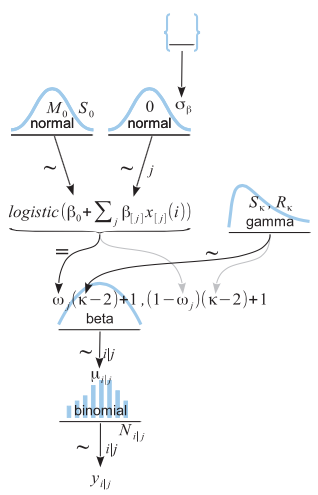

In [7]:
Image('images/fig21_12.png')

## Data Preparation

In [8]:
# 948 index number of the player's primary position
pripos_idx = df2.PriPos.cat.codes.values  
# The 9 position names
pripos_codes = df2.PriPos.cat.categories.values

n_pripos = pripos_codes.size      # 9
n_players = df2.Player.nunique()  # 948

data_prior = dict(n_pripos=n_pripos, pp_idx=pripos_idx, atBats=df2.AtBats.values)
#data = {**data_prior, **dict(Hits=df2.Hits.values)}
data = dict(n_pripos=n_pripos, pp_idx=pripos_idx, atBats=df2.AtBats.values, Hits=df2.Hits.values)
print(len(pripos_idx), pripos_codes.size, n_players)

948 9 948


## Modeling Building

In [9]:
def model(n_pripos, pp_idx, atBats, Hits=None):
    """
    input data arrays must be of jnp DeviceArray
    """
    aSigma = npr.sample('aSigma', dist.Gamma(1,64, 0.32))
    a0 = npr.sample('a0', dist.Normal(0, scale=2))  # scale == std
    
    with numpyro.plate('a_omega_plate', size=n_pripos):  # equivalent to running a for loop for 9 positions
        a = npr.sample('a', dist.Normal(0, scale=aSigma))
        omega = npr.deterministic("omega", jax.scipy.special.expit(a0 + a))
    #---------------------------
    m = a0 + a    
    b0 = m.mean()
    b = m - b0
    npr.deterministic('b0', b0)
    npr.deterministic('b', b)
    # --------------------------
    kappa = npr.sample('kappa', dist.Gamma(0.01, 0.01)) # the same conentration for all the players
    
    alpha = omega[pripos_idx]*kappa + 1   # deterministic, alpha[i] for each player
    beta = (1-omega[pripos_idx])*kappa + 1
    npr.deterministic('alpha', alpha)
    npr.deterministic('beta', beta)
    
    mu = npr.sample('mu', dist.Beta(alpha, beta))   # 
    # observation
    npr.sample('obs', dist.Binomial(total_count=atBats, probs=mu), obs=Hits)    
#

## Prior Predictive Sampling/Check

In [10]:
prior_samples = prior_predictive(model, data_prior)
type(prior_samples), prior_samples.keys()

(dict,
 dict_keys(['a', 'a0', 'aSigma', 'alpha', 'b', 'b0', 'beta', 'kappa', 'mu', 'obs', 'omega']))

In [11]:
[print(k, v.shape) for k,v in prior_samples.items()]

a (2021, 9)
a0 (2021,)
aSigma (2021,)
alpha (2021, 948)
b (2021, 9)
b0 (2021,)
beta (2021, 948)
kappa (2021,)
mu (2021, 948)
obs (2021, 948)
omega (2021, 9)


[None, None, None, None, None, None, None, None, None, None, None]

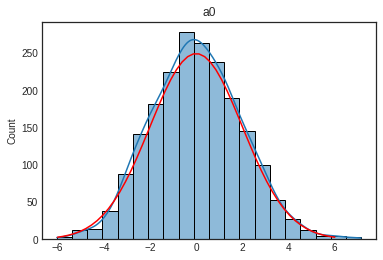

In [12]:
ax = sns.histplot(prior_samples['a0'], bins=20, kde=True, );
ax.set_title('a0')
x = np.linspace(-6, 6, 50)
ax.plot(x, stats.norm(0,2).pdf(x)*1250, 'r-');  # scaled to match the KDE

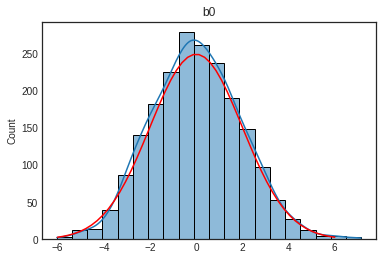

In [13]:
ax = sns.histplot(prior_samples['b0'], bins=20, kde=True, );
ax.set_title('b0')
x = np.linspace(-6, 6, 50)
ax.plot(x, stats.norm(0,2).pdf(x)*1250, 'r-');  # scaled to match the KDE

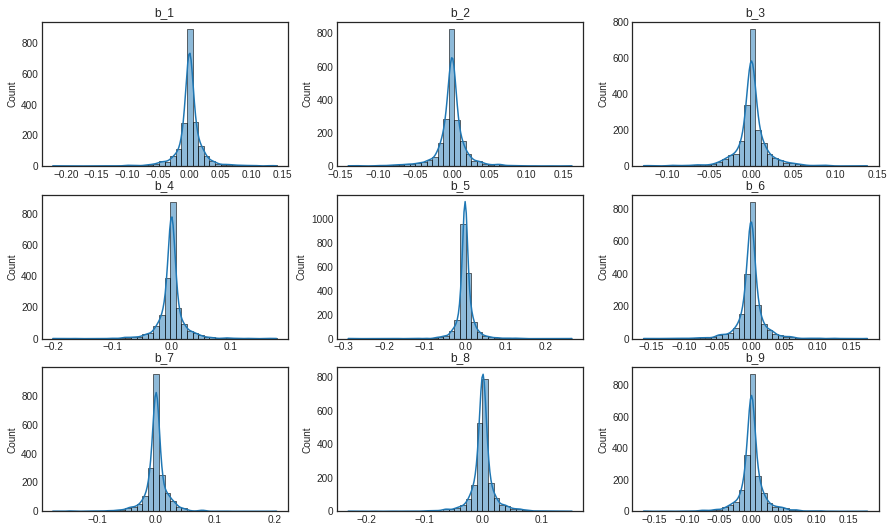

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(15,9))
for i, ax in enumerate(axes.ravel()):
    sns.histplot(prior_samples['b'][:,i], bins=40, kde=True, ax=ax);
    ax.set_title(f'b_{i+1}')

Most importantly, the prior distribution of $\mu_i$'s appear to be flat in the prior predictive samples. The observations are from $Bernoulli(\mu_i)$; so before we use the observation information, it should be just flat as we intend and it seems as we want.

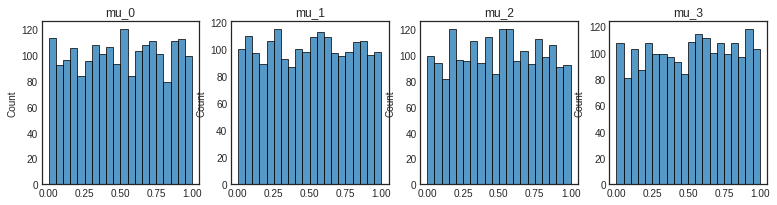

In [15]:
fig, axes = plt.subplots(1,4, figsize=(13,3))
for i, ax in enumerate(axes):
    sns.histplot(prior_samples['mu'][:,i], bins=20, ax=ax);
    ax.set_title(f'mu_{i}')

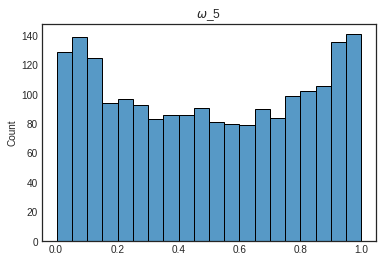

In [16]:
ax = sns.histplot(prior_samples['omega'][:,5], bins=20);
ax.set_title('$\omega$_5');

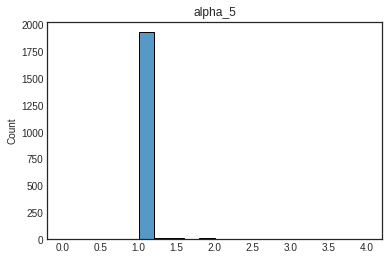

In [17]:
ax = sns.histplot(prior_samples['alpha'][:,5], bins=20, binrange=[0,4]);
ax.set_title('alpha_5');

## MCMC Sampling

In [22]:
%%time
posterior_samples = mcmc_sampling(data)

CPU times: user 3min 31s, sys: 39.6 s, total: 4min 10s
Wall time: 41.4 s


In [24]:
for k, v in posterior_samples.items(): print(k, v.shape)

a (8000, 9)
a0 (8000,)
aSigma (8000,)
alpha (8000, 948)
b (8000, 9)
b0 (8000,)
beta (8000, 948)
kappa (8000,)
mu (8000, 948)
omega (8000, 9)


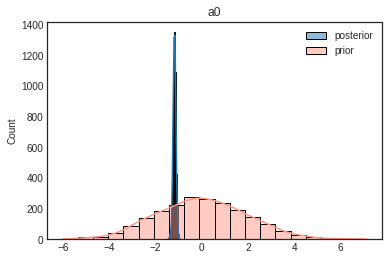

In [31]:
ax = sns.histplot(posterior_samples['a0'], bins=20, kde=True, label='posterior');
ax.set_title('a0')
sns.histplot(prior_samples['a0'], bins=20, kde=True, ax=ax, label='prior', color='#ff9988', alpha=.5);
ax.legend();

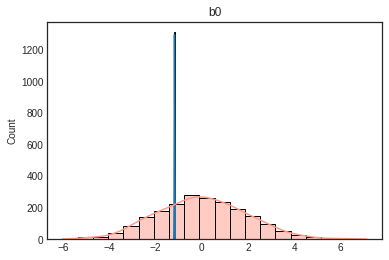

In [36]:
ax = sns.histplot(posterior_samples['b0'], bins=20, kde=True, label='posterior');
sns.histplot(prior_samples['b0'], bins=20, kde=True, label='prior', color='#ff9988', alpha=.5, ax=ax);
ax.set_title('b0');

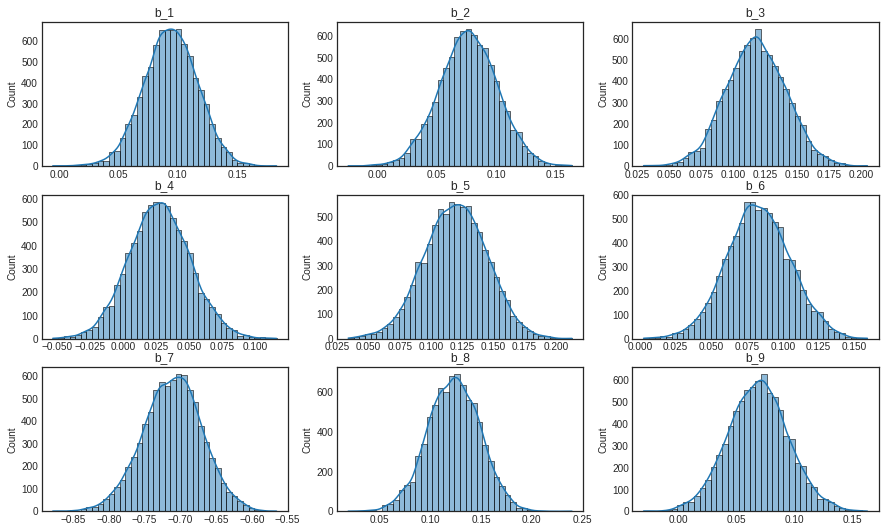

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(15,9))
for i, ax in enumerate(axes.ravel()):
#     sns.histplot(prior_samples['b'][:,i], bins=40, kde=True, ax=ax);
    sns.histplot(posterior_samples['b'][:,i], bins=40, kde=True, ax=ax);
    ax.set_title(f'b_{i+1}')

Most importantly, the prior distribution of $\mu_i$'s appear to be flat in the prior predictive samples. The observations are from $Bernoulli(\mu_i)$; so before we use the observation information, it should be just flat as we intend and it seems as we want.

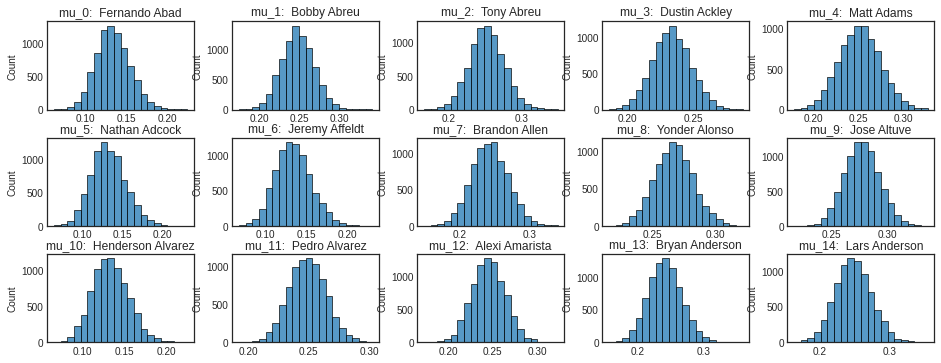

In [48]:
# Hit ability of each player
fig, axes = plt.subplots(3, 5, figsize=(13,5))
fig.tight_layout()
for i, ax in enumerate(axes.ravel()):
#     sns.histplot(prior_samples['mu'][:,i], bins=20, ax=ax);
    sns.histplot(posterior_samples['mu'][:,i], bins=20, ax=ax);
    ax.set_title(f'mu_{i}:  {df2.Player[i]}')

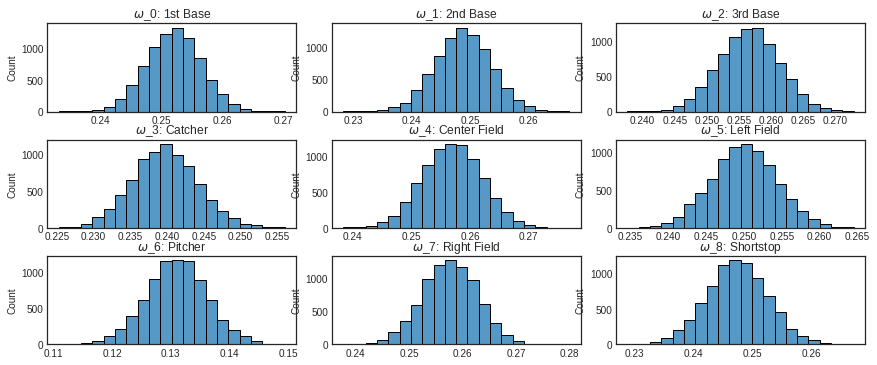

In [49]:
# Mode of the Hit ability by primary position
fig, axes = plt.subplots(3,3, figsize=(12,5))
fig.tight_layout()
for i, ax in enumerate(axes.ravel()):
    sns.histplot(posterior_samples['omega'][:,i], bins=20, ax=ax);
    ax.set_title(f'$\omega$_{i}: {pripos_codes[i]}');

### Figure 21.13
Instead of plotting different dot sizes to represent `AtBat`, we can use a gradient color scale. With help of the pandas `cut()` function we can assign the `AtBat` values to 5 bins and use these values with the `hue` parameter of the seaborn `stripplot` function.

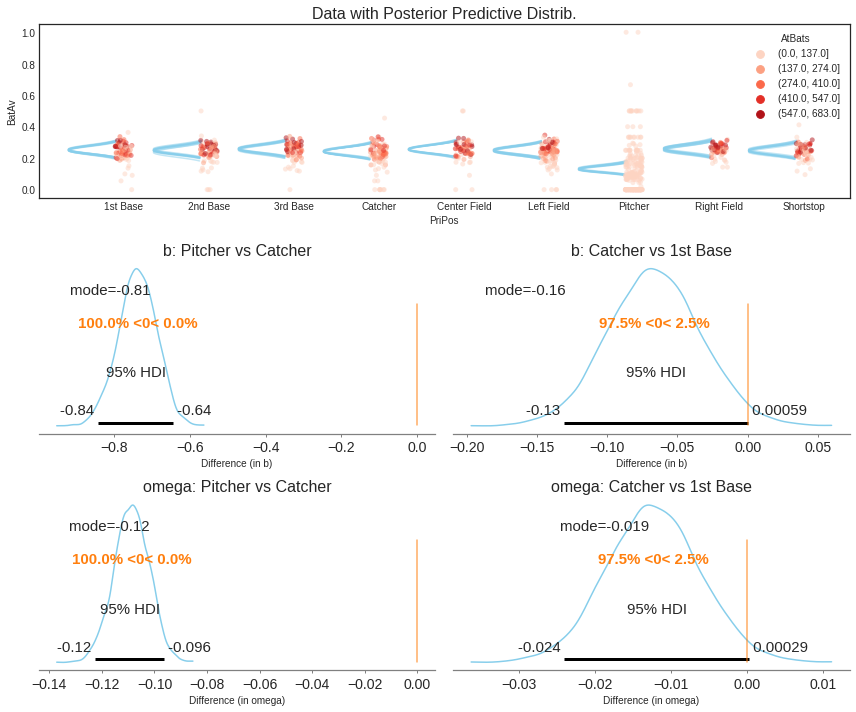

In [57]:
plt.figure(figsize=(12,10))
# Define gridspec
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

sns.stripplot(x='PriPos', y='BatAv', hue=pd.cut(df2.AtBats, 5, precision=0),
              data=df2, jitter=True, palette='Reds', ax=ax1, alpha=.5);

trace4 = posterior_samples
for pripos in np.arange(n_pripos):
    plot_mustache(trace4['omega'][:,pripos], trace4['kappa'], pripos, ax=ax1)
ax1.set_xlim(xmin=-1)
ax1.set_title('Data with Posterior Predictive Distrib.', fontdict=f_dict)
    
az.plot_posterior(trace4['b'][:,6]-trace4['b'][:,3],
                   ref_val=0, ax=ax2, point_estimate='mode', color=color, hdi_prob=.95)
ax2.set_title('b: Pitcher vs Catcher', fontdict=f_dict)
az.plot_posterior(trace4['b'][:,3]-trace4['b'][:,0],
                   ref_val=0, ax=ax3, point_estimate='mode', color=color, hdi_prob=.95)
ax3.set_title('b: Catcher vs 1st Base', fontdict=f_dict)
for ax in [ax2, ax3]:
    ax.set_xlabel('Difference (in b)')

az.plot_posterior(trace4['omega'][:,6]-trace4['omega'][:,3],
                   ref_val=0, ax=ax4, point_estimate='mode', color=color, hdi_prob=.95)
ax4.set_title('omega: Pitcher vs Catcher', fontdict=f_dict)
az.plot_posterior(trace4['omega'][:,3]-trace4['omega'][:,0],
                   ref_val=0, ax=ax5, point_estimate='mode', color=color, hdi_prob=.95)
ax5.set_title('omega: Catcher vs 1st Base', fontdict=f_dict)
for ax in [ax4, ax5]:
    ax.set_xlabel('Difference (in omega)')

plt.tight_layout();